# COGS 108 - EDA Checkpoint

# Names

- Victoria Thai
- Hannah Yick
- Jane Dinh
- Natasha Supangkat
- Gabriel Ramiro

<a id='research_question'></a>
# Research Question

What trends can be found between a county’s designation of a superfund site and its socioeconomic/demographic trends? Does the demographic makeup of a county influence the amount of time between Superfund designation and the completion of the remediation process?

# Setup

In [65]:
#Imports 
import pandas as pd
import numpy as np

#Graphing
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

#Statistics
import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

#Webscraping
import requests 
import bs4
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

# Read in the data and store it within a data frame
#npl_df = npl_df = pd.read_csv('https://raw.githubusercontent.com/COGS108/group011_sp21/main/All%20current%20Final%20NPL%20Sites%20(FOIA%204).csv?token=AI2VKGQIIMQPBWGAZGPKD5DASR4CO') 
gdrive_npl_id = '1oDIJ_v9s5i5THULln_C-N4o3Aiz0e7mu'
npl_df = pd.read_csv(f'https://docs.google.com/uc?id={gdrive_npl_id}&export=download', encoding='ISO-8859-1')
gdrive_acs_id = '1kNWY1Kc4RhQ9ttK7dTYtj0fhHE3BXOGh'
acs_df = pd.read_csv(f'https://docs.google.com/uc?id={gdrive_acs_id}&export=download', encoding='ISO-8859-1')

pd.options.display.max_rows = 5
pd.options.display.max_columns = 8

# Data Cleaning

Data cleaning from Checkpoint 1.

In [66]:
npl_df = npl_df.drop(["Region", "Site ID", "EPA ID", "Address", "Zip", "FF Ind", "Latitude", "Longitude"], axis=1)

In [67]:
acs_df = acs_df.drop([0], axis=0)
acs_df.reset_index(drop=True, inplace=True)

acs_df.dropna(axis = 0, how = 'all', inplace = True)
acs_df.dropna(axis = 1, how = 'all', inplace = True)

acs_df.drop(labels=['FIPS', 'Geographic Identifier', 'Summary Level', 'Geographic Component', 
                    'File identification', 'Logical Record Number', 'State (FIPS Code)', 
                    'County of current residence', 'Total Population.1', 'Population Density (Per Sq. Mile)', 
                    'Area (Land)', 'Total Population:', 'Total Population: White Alone', 
                    'Total Population: Black or African American Alone', 
                    'Total Population: American Indian and Alaska Native Alone', 'Total Population: Asian Alone', 
                    'Total Population: Native Hawaiian and Other Pacific Islander Alone', 
                    'Total Population: Some Other Race Alone', 'Total Population: Two or More Races'], axis=1, inplace = True)
acs_df.drop(index=acs_df[acs_df['State Postal Abbreviation'] == 'pr'].index, inplace=True)
acs_df.drop(list(acs_df.filter(regex = 'At or Above Poverty Level')), axis = 1, inplace = True)

acs_df = acs_df.iloc[:, np.r_[0:11, 12:23, 34, 37, 40, 43, 46, 49, 52, 55, 58, 61, 64, 67]]

We'll need to adjust our dataset now that we have a better understanding of our data and how we want to work with it. Here, we'll work towards merging our two datasets by county. Let's start by standardizing the county variable of both datasets with a format of 'COUNTY, PC' where PC is the postal code (i.e. CA for California). This will handle instances where there are counties of the same name in different states.

First, let's take a look at our NPL dataset.

In [68]:
npl_df.sample(n=10)

,State,Site Name,City,County,NPL Status Date
71,NH,SOUTH MUNICIPAL WATER SUPPLY WELL,PETERBOROUGH,HILLSBOROUGH,9/21/1984
1216,CA,OMEGA CHEMICAL CORPORATION,WHITTIER,LOS ANGELES,1/19/1999
...,...,...,...,...,...
193,NJ,SHERWIN-WILLIAMS/HILLIARDS CREEK,Gibbsboro,CAMDEN,3/19/2008
54,ME,WEST SITE/HOWS CORNERS,PLYMOUTH,PENOBSCOT,9/29/1995


Let's examine the dataset and check for missingness.

In [69]:
npl_df.isna().sum().sum()

20

In [70]:
npl_df.isna().any()

State              False
Site Name          False
City               False
County              True
NPL Status Date    False
dtype: bool

From this, we can see that all the missing data is in the County variable.

In [71]:
#subset to just rows with missing data
npl_df[npl_df.isnull().any(axis=1)]

,State,Site Name,City,County,NPL Status Date
266,NY,NEWTOWN CREEK,"BROOKLYN, QUEENS",NaN,9/29/2010
303,PR,FIBERS PUBLIC SUPPLY WELLS,JOBOS,NaN,9/21/1984
...,...,...,...,...,...
1263,ID,EASTERN MICHAUD FLATS CONTAMINATION,POCATELLO,NaN,8/30/1990
1264,ID,IDAHO NATIONAL ENGINEERING LABORATORY (USDOE),IDAHO FALLS,NaN,11/21/1989


We can see from the subset of missing data that these NPL sites are in valid cities in the United States, so there's no reason to drop them; however, they do not have data for the county. We will have to manually input these county values so that we can merge successfully before we go any further.

In [72]:
# manually input county names here

In [73]:
# clarify that all missing data has been addressed
npl_df.isna().sum().sum()

20

Now that all the county information is included, we'll convert the column names into lowercase, and continue this use of lowercase column names as we progress with both datasets as a standardization measure.

In [74]:
npl_df.columns = ['state', 'site name', 'city', 'county', 'npl status date']
npl_df.head()

,state,site name,city,county,npl status date
0,CT,BARKHAMSTED-NEW HARTFORD LANDFILL,BARKHAMSTED,LITCHFIELD,10/4/1989
1,CT,BEACON HEIGHTS LANDFILL,BEACON FALLS,NEW HAVEN,9/8/1983
2,CT,DURHAM MEADOWS,DURHAM,MIDDLESEX,10/4/1989
3,CT,GALLUP'S QUARRY,PLAINFIELD,WINDHAM,10/4/1989
4,CT,KELLOGG-DEERING WELL FIELD,NORWALK,FAIRFIELD,9/21/1984


Next we'll get our county variable information into the correct format by concatenating the state postal code.

In [75]:
npl_df['county'] = npl_df['county'].map(str) + ', ' + npl_df['state'].map(str)
npl_df.head()

,state,site name,city,county,npl status date
0,CT,BARKHAMSTED-NEW HARTFORD LANDFILL,BARKHAMSTED,"LITCHFIELD, CT",10/4/1989
1,CT,BEACON HEIGHTS LANDFILL,BEACON FALLS,"NEW HAVEN, CT",9/8/1983
2,CT,DURHAM MEADOWS,DURHAM,"MIDDLESEX, CT",10/4/1989
3,CT,GALLUP'S QUARRY,PLAINFIELD,"WINDHAM, CT",10/4/1989
4,CT,KELLOGG-DEERING WELL FIELD,NORWALK,"FAIRFIELD, CT",9/21/1984


In addition, we added a Duration column that will come into play as we plot our data. The values in this variable are the number of years since NPL status for the site was established (up to 2021).

In [76]:
npl_df['duration'] = npl_df['npl status date'].str[-4:]
npl_df = npl_df.astype({"duration": int})
npl_df['duration'] = 2021 - npl_df['duration']
npl_df

,state,site name,city,county,npl status date,duration
0,CT,BARKHAMSTED-NEW HARTFORD LANDFILL,BARKHAMSTED,"LITCHFIELD, CT",10/4/1989,32
1,CT,BEACON HEIGHTS LANDFILL,BEACON FALLS,"NEW HAVEN, CT",9/8/1983,38
...,...,...,...,...,...,...
1325,WA,"WESTERN PROCESSING CO., INC.",KENT,"KING, WA",9/8/1983,38
1326,WA,WYCKOFF CO./EAGLE HARBOR,BAINBRIDGE ISLAND,"KITSAP, WA",7/22/1987,34


Now we can take a look at our ACS dataset.

In [77]:
acs_df.head()

,Area Name,Qualifying Name,State Postal Abbreviation,Total Population,...,% Some Other Race Alone Population for Whom Poverty Status Is Determined: Income Below Poverty Level,% Two or More Races Population for Whom Poverty Status Is Determined: Income Below Poverty Level,% Hispanic or Latino Population for Whom Poverty Status Is Determined: Income Below Poverty Level,"% White Alone, Not Hispanic or Latino Population for Whom&nbsp; Poverty Status Is Determined: Income Below Poverty Level"
0,Autauga County,"Autauga County, Alabama",al,55380,...,26.19,16.97,4.37,11.12
1,Baldwin County,"Baldwin County, Alabama",al,212830,...,26.28,10.79,18.41,8.4
2,Barbour County,"Barbour County, Alabama",al,25361,...,50.34,55.85,61.25,14.71
3,Bibb County,"Bibb County, Alabama",al,22493,...,NaN,0,0,16.34
4,Blount County,"Blount County, Alabama",al,57681,...,2.64,19.1,25.46,12.33


We'll need to standardize the formatting for the column describing the county of each observation to match that of our NPL datset, which is of the format 'COUNTY, PC' with PC being the postal code abbreviation. We can achieve this using the .upper(), .replace(), and .strip() methods.

In [78]:
acs_df.rename({'Area Name': 'county'}, axis=1, inplace=True)
acs_df['State Postal Abbreviation'] = acs_df['State Postal Abbreviation'].str.upper()
acs_df['county'] = acs_df['county'].str.upper()
acs_df['county'] = acs_df['county'].str.replace('COUNTY', '')
acs_df['county'] = acs_df['county'].str.strip()
acs_df['county'] = acs_df['county'].map(str) + ', ' + acs_df['State Postal Abbreviation'].map(str)
acs_df.head()

,county,Qualifying Name,State Postal Abbreviation,Total Population,...,% Some Other Race Alone Population for Whom Poverty Status Is Determined: Income Below Poverty Level,% Two or More Races Population for Whom Poverty Status Is Determined: Income Below Poverty Level,% Hispanic or Latino Population for Whom Poverty Status Is Determined: Income Below Poverty Level,"% White Alone, Not Hispanic or Latino Population for Whom&nbsp; Poverty Status Is Determined: Income Below Poverty Level"
0,"AUTAUGA, AL","Autauga County, Alabama",AL,55380,...,26.19,16.97,4.37,11.12
1,"BALDWIN, AL","Baldwin County, Alabama",AL,212830,...,26.28,10.79,18.41,8.4
2,"BARBOUR, AL","Barbour County, Alabama",AL,25361,...,50.34,55.85,61.25,14.71
3,"BIBB, AL","Bibb County, Alabama",AL,22493,...,NaN,0,0,16.34
4,"BLOUNT, AL","Blount County, Alabama",AL,57681,...,2.64,19.1,25.46,12.33


Now that we have a common column, we can merge our datasets. We'll use a left merge with our NPL dataset as our left-dataset, since we only need the demographic data for the county of the NPL sites.

In [79]:
county_df = pd.merge(npl_df, acs_df, on='county', how='left')
county_df = county_df.sort_values(by=['county'])
county_df.sample(n=5)

,state,site name,city,county,...,% Some Other Race Alone Population for Whom Poverty Status Is Determined: Income Below Poverty Level,% Two or More Races Population for Whom Poverty Status Is Determined: Income Below Poverty Level,% Hispanic or Latino Population for Whom Poverty Status Is Determined: Income Below Poverty Level,"% White Alone, Not Hispanic or Latino Population for Whom&nbsp; Poverty Status Is Determined: Income Below Poverty Level"
83,RI,PICILLO FARM,COVENTRY,"KENT, RI",...,20.12,9.17,9.8,7.41
566,KY,B.F. GOODRICH,CALVERT CITY,"MARSHALL, KY",...,31.82,4.99,2.95,10.5
969,TX,CONROE CREOSOTING CO.,CONROE,"MONTGOMERY, TX",...,15.15,11.78,17.5,6.19
500,FL,"AMERICAN CREOSOTE WORKS, INC. (PENSACOLA PLANT)",PENSACOLA,"ESCAMBIA, FL",...,29.32,22.52,21.05,9.98
143,NJ,HIGGINS DISPOSAL,KINGSTON,"SOMERSET, NJ",...,18.65,9.61,9.68,3.26


In [80]:
county_df.isna().sum().sum()

3735

# Data Analysis & Results (EDA)

### Median Household Income

Let's narrow down the scope of our dataset for this portion - we'll create a subset using just the relevant variables, including county, site name, and median household income. We'll also drop any rows in the subset with missing data for median household income, as this is essential to our current exploration.

In [81]:
mhi_df = county_df[['site name', 'county', 'Median Household Income (In 2019 Inflation Adjusted Dollars):']]
mhi_df.rename({'Median Household Income (In 2019 Inflation Adjusted Dollars):': 'median household income'}, axis=1, inplace=True)
mhi_df = mhi_df.dropna(subset=['median household income'])
mhi_df['median household income'] = mhi_df['median household income'].astype(int)
mhi_df

,site name,county,median household income
1094,BRODERICK WOOD PRODUCTS,"ADAMS, CO",71202
1107,ROCKY MOUNTAIN ARSENAL (USARMY),"ADAMS, CO",71202
...,...,...,...
461,LANGLEY AIR FORCE BASE/NASA LANGLEY RESEARCH C...,"YORK, VA",92069
1152,YUMA MARINE CORPS AIR STATION,"YUMA, AZ",45243


Visualizing the distribution of median household income for all of the relevant counties might be difficult - we have thousands of observations. We'll create two more subsets and compare their distributions:
1. 10 counties with the most NPL sites
2. 10 counties with the least NPL sites

We can start by getting a list of counties in order of their frequency in the dataset; we'll use the .value_counts() and .index.tolist() methods.

In [82]:
mhi_df.value_counts(['county'])

county         
SANTA CLARA, CA    21
MONTGOMERY, PA     17
                   ..
HIDALGO, TX         1
YUMA, AZ            1
Length: 615, dtype: int64

In [83]:
counties = mhi_df['county'].value_counts().index.tolist()

Now let's create the subsets by slicing the list into two lists of 10 counties.

In [84]:
top_10 = counties[0:10]
bottom_10 = counties[506:516]

In [85]:
top_10

['SANTA CLARA, CA',
 'LOS ANGELES, CA',
 'MONTGOMERY, PA',
 'NASSAU, NY',
 'MIDDLESEX, MA',
 'MIDDLESEX, NJ',
 'HARRIS, TX',
 'HILLSBOROUGH, FL',
 'NEW CASTLE, DE',
 'BURLINGTON, NJ']

In [86]:
mhi_top_df = mhi_df[mhi_df['county'].isin(top_10)]
#mhi_df[mhi_df['county'] == 'MONTGOMERY, PA']
mhi_top_df.head()

,site name,county,median household income
153,LANG PROPERTY,"BURLINGTON, NJ",87416
189,ROEBLING STEEL CO.,"BURLINGTON, NJ",87416
114,CINNAMINSON TOWNSHIP (BLOCK 702) GROUND WATER ...,"BURLINGTON, NJ",87416
152,LANDFILL & DEVELOPMENT CO.,"BURLINGTON, NJ",87416
117,COSDEN CHEMICAL COATINGS CORP.,"BURLINGTON, NJ",87416


Text(0, 0.5, 'County')

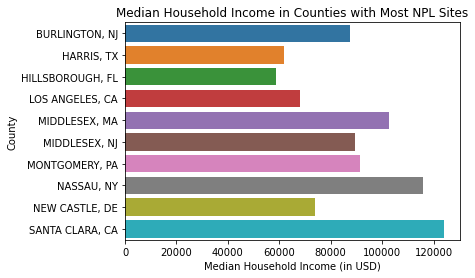

In [93]:
ax = sns.barplot(x="median household income", y="county", data=mhi_top_df)

# add title and axis labels (modify x-axis label)
ax.set_title('Median Household Income in Counties with Most NPL Sites')
ax.set_xlabel('Median Household Income (in USD)')
ax.set_ylabel('County')

In [88]:
bottom_10

['LAKE, OR',
 'HANCOCK, ME',
 'PARKER, TX',
 'CALHOUN, TX',
 'ALLEGANY, MD',
 'CLARK, IL',
 'BELL, TX',
 'SAN BENITO, CA',
 'CUMBERLAND, PA',
 'MIFFLIN, PA']

In [89]:
mhi_bottom_df = mhi_df[mhi_df['county'].isin(bottom_10)]

Text(0, 0.5, 'County')

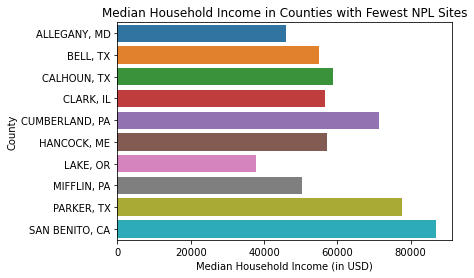

In [92]:
ax = sns.barplot(x="median household income", y="county", data=mhi_bottom_df)

# add title and axis labels (modify x-axis label)
ax.set_title('Median Household Income in Counties with Fewest NPL Sites')
ax.set_xlabel('Median Household Income (in USD)')
ax.set_ylabel('County')

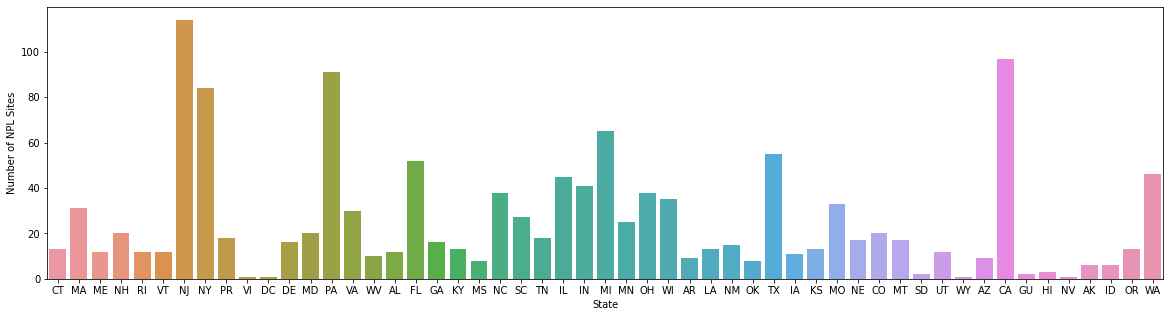

In [91]:
plt.figure(figsize=(20,5))
ax = sns.countplot(x='state', data=npl_df);
ax.set_xticklabels(ax.get_xticklabels())
ax.set(xlabel='State', ylabel='Number of NPL Sites')
plt.show()